# Fully Connected Experiments


## 1. Imports and loading datasets

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import semitorch

from copy import deepcopy
from collections import OrderedDict
from IPython import display
from random import uniform
from statistics import quantiles
from torch.utils.data import DataLoader
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../../data")
device = "cuda" if torch.cuda.is_available() else "cpu"


def split_dataset(dataset: torch.utils.data.Dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    return torch.utils.data.random_split(dataset, [train_size, test_size])

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load iris data
[https://www.kaggle.com/datasets/uciml/iris](https://www.kaggle.com/datasets/uciml/iris)

In [2]:
iris_df = pd.read_csv(
    os.path.join(data_path, "iris.csv"), index_col=0, dtype={"Species": "string"}
)
iris_x = torch.Tensor(iris_df.iloc[:, [0, 1, 2, 3]].to_numpy()).to(device)

iris_y = (
    iris_df["Species"]
    .map({
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2,
    }).to_numpy()
)
iris_y = torch.Tensor(iris_y).to(torch.int64).to(device)
print(f"Iris dataset: input features = {iris_x.shape[1]}, "
      f"classes = {torch.unique(iris_y).shape[0]}, "
      f"samples = {len(iris_y)}")

# normalize
torch.nn.functional.normalize(iris_x, dim=0, out=iris_x)

iris_train, iris_test = split_dataset(torch.utils.data.TensorDataset(iris_x, iris_y))

Iris dataset: input features = 4, classes = 3, samples = 150


tensor([[0.0706, 0.0927, 0.0275, 0.0115],
        [0.0678, 0.0794, 0.0275, 0.0115],
        [0.0650, 0.0847, 0.0256, 0.0115],
        [0.0636, 0.0821, 0.0295, 0.0115],
        [0.0692, 0.0953, 0.0275, 0.0115],
        [0.0747, 0.1032, 0.0334, 0.0230],
        [0.0636, 0.0900, 0.0275, 0.0173],
        [0.0692, 0.0900, 0.0295, 0.0115],
        [0.0609, 0.0768, 0.0275, 0.0115],
        [0.0678, 0.0821, 0.0295, 0.0058],
        [0.0747, 0.0979, 0.0295, 0.0115],
        [0.0664, 0.0900, 0.0315, 0.0115],
        [0.0664, 0.0794, 0.0275, 0.0058],
        [0.0595, 0.0794, 0.0216, 0.0058],
        [0.0802, 0.1059, 0.0236, 0.0115],
        [0.0789, 0.1165, 0.0295, 0.0230],
        [0.0747, 0.1032, 0.0256, 0.0230],
        [0.0706, 0.0927, 0.0275, 0.0173],
        [0.0789, 0.1006, 0.0334, 0.0173],
        [0.0706, 0.1006, 0.0295, 0.0173],
        [0.0747, 0.0900, 0.0334, 0.0115],
        [0.0706, 0.0979, 0.0295, 0.0230],
        [0.0636, 0.0953, 0.0197, 0.0115],
        [0.0706, 0.0874, 0.0334, 0

### Load heart disease data

[https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)

In [3]:
heart_df = pd.read_csv(os.path.join(data_path, "heart.csv"))
heart_x = (torch.Tensor(heart_df.iloc[:, range(13)].to_numpy()).to(torch.float32).to(device))
heart_y = torch.Tensor(heart_df.iloc[:, -1].to_numpy()).to(torch.int64).to(device)

print(f"Heart disease dataset: input features = {heart_x.shape[1]}, "
      f"classes = {torch.unique(heart_y).shape[0]}, "
      f"samples = {len(heart_y)}")

# normalize
torch.nn.functional.normalize(heart_x, dim=0, out=heart_x)

heart_train, heart_test = split_dataset(torch.utils.data.TensorDataset(heart_x, heart_y))

Heart disease dataset: input features = 13, classes = 2, samples = 303


tensor([[0.0657, 0.0695, 0.1220,  ..., 0.0000, 0.0000, 0.0240],
        [0.0386, 0.0695, 0.0813,  ..., 0.0000, 0.0000, 0.0480],
        [0.0427, 0.0000, 0.0407,  ..., 0.0752, 0.0000, 0.0480],
        ...,
        [0.0709, 0.0695, 0.0000,  ..., 0.0376, 0.0916, 0.0720],
        [0.0594, 0.0695, 0.0000,  ..., 0.0376, 0.0458, 0.0720],
        [0.0594, 0.0000, 0.0407,  ..., 0.0376, 0.0458, 0.0480]],
       device='cuda:0')

### Load Naitzat data

[https://github.com/topnn/topnn_framework](https://github.com/topnn/topnn_framework)

In [4]:
circles_x, circles_y = torch.load(os.path.join(data_path, "naitzat", "circles_type_8.pt"))
circles_y = torch.squeeze(circles_y)
circles_train, circles_test = split_dataset(torch.utils.data.TensorDataset(circles_x, circles_y))
print(f"Circles dataset: input features = {circles_x.shape[1]}, "
      f"classes = {torch.unique(circles_y).shape[0]}, "
      f"samples = {len(circles_y)}")

rings_x, rings_y = torch.load(os.path.join(data_path, "naitzat", "rings_9.pt"))
rings_y = torch.squeeze(rings_y)
rings_train, rings_test = split_dataset(torch.utils.data.TensorDataset(rings_x, rings_y))
print(f"Rings dataset: input features = {rings_x.shape[1]}, "
      f"classes = {torch.unique(rings_y).shape[0]}, "
      f"samples = {len(rings_y)}")

spheres_x, spheres_y = torch.load(os.path.join(data_path, "naitzat", "spheres_9.pt"))
spheres_y = torch.squeeze(spheres_y)
spheres_train, spheres_test = split_dataset(torch.utils.data.TensorDataset(spheres_x, spheres_y))
print(f"Spheres dataset: input features = {spheres_x.shape[1]}, "
      f"classes = {torch.unique(spheres_y).shape[0]}, "
      f"samples = {len(spheres_y)}")

Circles dataset: input features = 2, classes = 2, samples = 15950
Rings dataset: input features = 3, classes = 2, samples = 45000
Spheres dataset: input features = 3, classes = 2, samples = 37800


## 2. Models setup

In [5]:
def create_model(
        model_name: str,
        num_features: int,
        num_classes: int,
        num_layers: int = 1,
        channel_size: int = 16,
) -> nn.Sequential:
    BACKBONE_FEATURES = channel_size

    if model_name == "linear_relu":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     nn.ReLU(),
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     nn.ReLU(),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES, device=device),
            nn.ReLU(),
            nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
            nn.ReLU(),
            *layers,
        )
    elif model_name == "linear_maxplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     semitorch.MaxPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES, device=device),
            semitorch.MaxPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
            *layers,
        )
    elif model_name == "linear_minplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     semitorch.MinPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES, device=device),
            semitorch.MinPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
            *layers,
        )
    elif model_name == "linear_logplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     semitorch.LogPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, mu=1, device=device),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES, device=device),
            semitorch.LogPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, mu=1, device=device),
            *layers,
        )
    elif model_name == "linear_logmin":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES, device=device),
                     semitorch.LogPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, mu=-1, device=device),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES, device=device),
            semitorch.LogPlusMP(BACKBONE_FEATURES, BACKBONE_FEATURES, mu=-1, device=device),
            *layers,
        )
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    head = nn.Linear(BACKBONE_FEATURES, num_classes, bias=False, device=device)
    model = nn.Sequential(OrderedDict([("backbone", backbone), ("head", head)]))

    model.name = model_name

    return model


def count_parameters(model: nn.Sequential) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 3. Training functions

In [6]:
def accuracy(model: nn.Sequential, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Sequential, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def train(
        model: nn.Sequential,
        device: str,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        loss: torch.nn.modules.loss,
        epochs: int,
        statistics_mode: bool = False
) -> float | None:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    if not statistics_mode:
        fig, ax = plt.subplots(1, 1, figsize=[6, 4])
        hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)

            if not statistics_mode:
                _, prediction = torch.max(yout.cpu(), dim=1)
                trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        accs.append(test(model, testloader))

        if not statistics_mode:
            ax.clear()
            ax.set_xlim(0, epochs)
            ax.set_ylim(-0.02, 1.02)
            ax.plot(
                np.linspace(0, len(accs), len(trainaccs)),
                trainaccs,
                ".",
                markersize=1.5,
                markerfacecolor=(0, 0, 1, 0.3),
            )
            ax.plot(np.linspace(1, len(accs), len(accs)), accs)
            ax.text(
                0.6 * epochs,
                0.80,
                f"max test acc = {max(accs):.2%}",
                ha="center",
                fontsize=10,
            )
            hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    if statistics_mode:
        return max(accs)


def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)

Random search hyperparameter optimisation functions

In [7]:
def run_model_for_config(config: dict) -> dict:
    loss = nn.CrossEntropyLoss()

    # Get parameters
    model_name = config["model_name"]
    lr = config["lr"]
    num_features = config["features"]
    num_classes = config["classes"]
    num_layers = config["layers"]
    channel_size = config["channels"]
    trainloader = config["trainloader"]
    testloader = config["testloader"]
    epochs = config["epochs"]

    # Create model
    model = create_model(model_name=model_name, num_features=num_features, num_classes=num_classes,
                         num_layers=num_layers, channel_size=channel_size).to(device)

    # Create optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(trainloader),
        epochs=epochs,
    )

    reported_accuracy = 0
    for epoch in range(epochs):
        print(f"{epoch=}")

        # Feed to training function
        reported_accuracy = train_model(
            model,
            trainloader,
            testloader,
            optimizer,
            scheduler,
            loss,
            epoch == (epochs - 1),
        )

    return {"accuracy": reported_accuracy, "config": config}


def train_model(
        model: nn.Sequential,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        loss: torch.nn.modules.loss,
        final_epoch: bool,
) -> float:
    model.train()

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        l = loss(model(x), y.squeeze())
        l.backward()

        optimizer.step()
        scheduler.step()

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    if final_epoch:
        return test(model, testloader)
    else:
        return 0.0


def run_random_search_for_config(config: dict) -> dict:
    best_accuracy, best_config, current_config = 0, deepcopy(config), deepcopy(config)
    step_size, bad_step_counter, good_step_counter = 0.1, 0, 0
    for update_step in range(5):
        print(f"{update_step=}")
        result = run_model_for_config(current_config)
        print(f"update_step done")

        if result["accuracy"] > best_accuracy:
            bad_step_counter = 0
            good_step_counter += 1

            best_accuracy, best_config = result["accuracy"], deepcopy(current_config)
        else:
            bad_step_counter += 1
            good_step_counter = 0

        if bad_step_counter > 10:
            break  # Terminate run, likely no better accuracy possible

        current_config, step_size, bad_step_counter, good_step_counter = adaptive_step_update_config(
            config=deepcopy(best_config),
            step_size=step_size,
            bad_step_counter=bad_step_counter,
            good_step_counter=good_step_counter,
        )

        if step_size < 1e-2:
            # Step size too small to make any impact, terminate run
            break

    return {"accuracy": best_accuracy, "config": best_config}


def adaptive_step_update_config(
        config: dict,
        step_size: float,
        bad_step_counter: int,
        good_step_counter: int,
) -> tuple[dict, float, int, int]:
    # Update step_size
    if bad_step_counter > 2:
        step_size /= 2
        bad_step_counter = 0
    if (good_step_counter > 2) and (step_size < 0.5):
        step_size *= 2
        good_step_counter = 0

    # Update config values
    config["lr"] = uniform(
        config["lr"] * (1 - step_size),
        config["lr"] * (1 + step_size),
    )

    return config, step_size, bad_step_counter, good_step_counter


def find_best_model_for(config: dict) -> None:
    current_config = create_random_config_for_model(deepcopy(config))

    print(f"Starting run for config {current_config}")
    result = run_random_search_for_config(current_config)

    display.clear_output(wait=True)
    print(result)


def create_random_config_for_model(config: dict) -> dict:
    config["lr"] = 10 ** uniform(-1.5, -1)

    return config

In [8]:
iris_train_loader = DataLoader(iris_train, batch_size=8, shuffle=True)
iris_test_loader = DataLoader(iris_test, batch_size=len(iris_test), shuffle=False)

heart_train_loader = DataLoader(heart_train, batch_size=32, shuffle=True)
heart_test_loader = DataLoader(heart_test, batch_size=len(heart_test))

circles_train_loader = DataLoader(circles_train, batch_size=16, shuffle=True)
circles_test_loader = DataLoader(circles_test, batch_size=len(circles_test), shuffle=True)

rings_train_loader = DataLoader(rings_train, batch_size=16, shuffle=True)
rings_test_loader = DataLoader(rings_test, batch_size=len(rings_test), shuffle=True)

spheres_train_loader = DataLoader(spheres_train, batch_size=16, shuffle=True)
spheres_test_loader = DataLoader(spheres_test, batch_size=len(spheres_test), shuffle=True)

# 4. Results

For every dataset:
&emsp;For every model:
&emsp;&emsp;Run random search to find best learning rate
&emsp;&emsp;Run best model
&emsp;&emsp;Run best model 100 times to get statistics data (for boxplot: min, 25%, 50%, 75%, max)

# Iris

In [18]:
find_best_model_for(config={
    "model_name": "linear_relu",
    "features": 4,
    "classes": 3,
    "layers": 1,
    "channels": 16,
    "trainloader": iris_train_loader,
    "testloader": iris_test_loader,
    "epochs": 40
})

{'accuracy': 0.9666666666666667, 'config': {'model_name': 'linear_relu', 'features': 4, 'classes': 3, 'layers': 1, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221A06B2920>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221A06B0F10>, 'epochs': 40, 'lr': 0.01914745129825722}}


In [19]:
find_best_model_for(config={
    "model_name": "linear_maxplus",
    "features": 4,
    "classes": 3,
    "layers": 1,
    "channels": 16,
    "trainloader": iris_train_loader,
    "testloader": iris_test_loader,
    "epochs": 40
})

{'accuracy': 0.9333333333333333, 'config': {'model_name': 'linear_maxplus', 'features': 4, 'classes': 3, 'layers': 1, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221F0CDD2D0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221F0CDD240>, 'epochs': 40, 'lr': 0.046899957999425035}}


In [20]:
find_best_model_for(config={
    "model_name": "linear_minplus",
    "features": 4,
    "classes": 3,
    "layers": 1,
    "channels": 16,
    "trainloader": iris_train_loader,
    "testloader": iris_test_loader,
    "epochs": 40
})

{'accuracy': 0.9333333333333333, 'config': {'model_name': 'linear_minplus', 'features': 4, 'classes': 3, 'layers': 1, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221F0C03F70>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221AE296EC0>, 'epochs': 40, 'lr': 0.09103117359604594}}


In [21]:
find_best_model_for(config={
    "model_name": "linear_logplus",
    "features": 4,
    "classes": 3,
    "layers": 1,
    "channels": 16,
    "trainloader": iris_train_loader,
    "testloader": iris_test_loader,
    "epochs": 40
})

{'accuracy': 0.9333333333333333, 'config': {'model_name': 'linear_logplus', 'features': 4, 'classes': 3, 'layers': 1, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221AE4FB880>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221A06B3760>, 'epochs': 40, 'lr': 0.060566598048920485}}


In [22]:
find_best_model_for(config={
    "model_name": "linear_logmin",
    "features": 4,
    "classes": 3,
    "layers": 1,
    "channels": 16,
    "trainloader": iris_train_loader,
    "testloader": iris_test_loader,
    "epochs": 40
})

{'accuracy': 0.9333333333333333, 'config': {'model_name': 'linear_logmin', 'features': 4, 'classes': 3, 'layers': 1, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221AE2974F0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000221AE297DF0>, 'epochs': 40, 'lr': 0.06965391904048887}}


linear/relu model has 400 trainable parameters
linear/maxplus model has 400 trainable parameters
linear/minplus model has 400 trainable parameters
linear/logplus model has 401 trainable parameters
linear/logmin model has 401 trainable parameters


''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

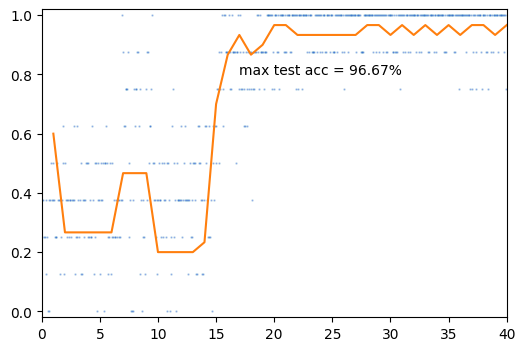

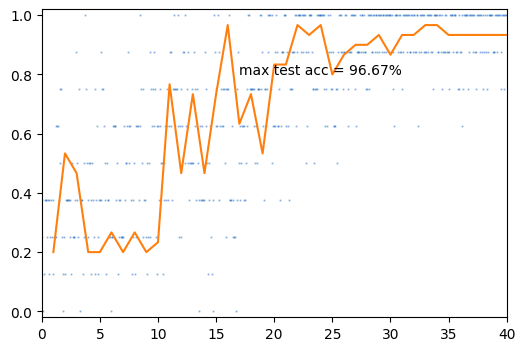

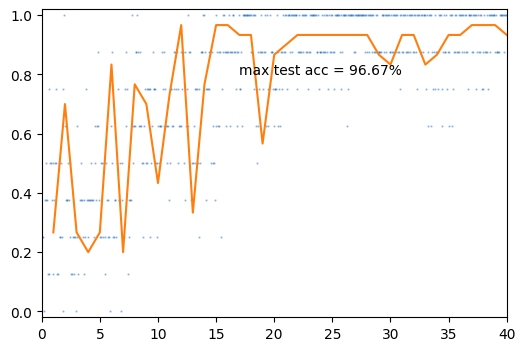

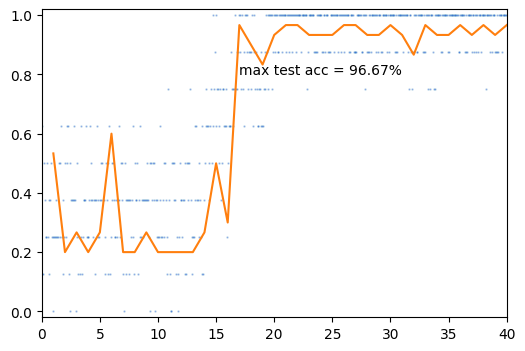

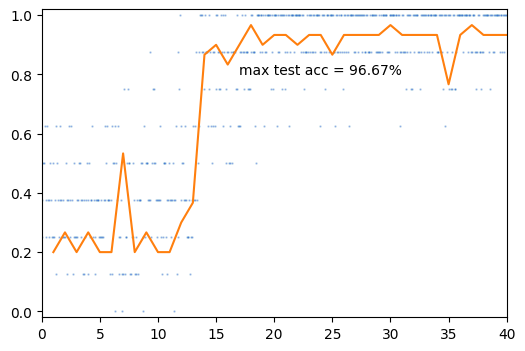

In [29]:
iris_models = [
    create_model("linear_relu", num_features=4, num_classes=3).to(device),
    create_model("linear_maxplus", num_features=4, num_classes=3).to(device),
    create_model("linear_minplus", num_features=4, num_classes=3).to(device),
    create_model("linear_logplus", num_features=4, num_classes=3).to(device),
    create_model("linear_logmin", num_features=4, num_classes=3).to(device),
]

for model in iris_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in iris_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01914745129825722)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.01914745129825722,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.046899957999425035)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.046899957999425035,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.09103117359604594)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.09103117359604594,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_logplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.060566598048920485)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.060566598048920485,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_logmin":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.06965391904048887)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.06965391904048887,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        iris_train_loader,
        iris_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [9]:
linear_accs = []
maxplus_accs = []
minplus_accs = []
logplus_accs = []
logmin_accs = []

for i in range(100):
    print(i)
    iris_models = [
        create_model("linear_relu", num_features=4, num_classes=3).to(device),
        create_model("linear_maxplus", num_features=4, num_classes=3).to(device),
        create_model("linear_minplus", num_features=4, num_classes=3).to(device),
        create_model("linear_logplus", num_features=4, num_classes=3).to(device),
        create_model("linear_logmin", num_features=4, num_classes=3).to(device),
    ]

    loss = nn.CrossEntropyLoss()
    epochs = 40

    for model in iris_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.01914745129825722)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.01914745129825722,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )

            linear_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.046899957999425035)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.046899957999425035,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.09103117359604594)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.09103117359604594,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )

            minplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.060566598048920485)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.060566598048920485,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )

            logplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logmin":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.06965391904048887)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.06965391904048887,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )

            logmin_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")

    display.clear_output(wait=True)

print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))
print('-----')
print(min(logplus_accs))
print(quantiles(logplus_accs))
print(max(logplus_accs))
print('-----')
print(min(logmin_accs))
print(quantiles(logmin_accs))
print(max(logmin_accs))

0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667
-----
0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667
-----
0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
1.0
-----
0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667
-----
0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667


# Heart

In [30]:
find_best_model_for(config={
    "model_name": "linear_relu",
    "features": 13,
    "classes": 2,
    "layers": 2,
    "channels": 16,
    "trainloader": heart_train_loader,
    "testloader": heart_test_loader,
    "epochs": 40,
})

{'accuracy': 0.8360655737704918, 'config': {'model_name': 'linear_relu', 'features': 13, 'classes': 2, 'layers': 2, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001A4DC70B880>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001A4E22E6230>, 'epochs': 40, 'lr': 0.09535234966273315}}


In [31]:
find_best_model_for(config={
    "model_name": "linear_maxplus",
    "features": 13,
    "classes": 2,
    "layers": 2,
    "channels": 16,
    "trainloader": heart_train_loader,
    "testloader": heart_test_loader,
    "epochs": 40,
})

{'accuracy': 0.819672131147541, 'config': {'model_name': 'linear_maxplus', 'features': 13, 'classes': 2, 'layers': 2, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001A5230ABFD0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001A5230AA3B0>, 'epochs': 40, 'lr': 0.08645911829739474}}


In [26]:
find_best_model_for(config={
    "model_name": "linear_minplus",
    "features": 13,
    "classes": 2,
    "layers": 2,
    "channels": 16,
    "trainloader": heart_train_loader,
    "testloader": heart_test_loader,
    "epochs": 40,
})

{'accuracy': 0.7377049180327869, 'config': {'model_name': 'linear_minplus', 'features': 13, 'classes': 2, 'layers': 2, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F3C5DD450>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F7943F040>, 'epochs': 40, 'lr': 0.0641828174926708}}


In [24]:
find_best_model_for(config={
    "model_name": "linear_logplus",
    "features": 13,
    "classes": 2,
    "layers": 2,
    "channels": 16,
    "trainloader": heart_train_loader,
    "testloader": heart_test_loader,
    "epochs": 40,
})

{'accuracy': 0.7377049180327869, 'config': {'model_name': 'linear_logplus', 'features': 13, 'classes': 2, 'layers': 2, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F3C5DD1B0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F7943C7C0>, 'epochs': 40, 'lr': 0.08740666664969698}}


In [28]:
find_best_model_for(config={
    "model_name": "linear_logmin",
    "features": 13,
    "classes": 2,
    "layers": 2,
    "channels": 16,
    "trainloader": heart_train_loader,
    "testloader": heart_test_loader,
    "epochs": 40,
})

{'accuracy': 0.7540983606557377, 'config': {'model_name': 'linear_logmin', 'features': 13, 'classes': 2, 'layers': 2, 'channels': 16, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F7FC38C10>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000023F7FC3BE80>, 'epochs': 40, 'lr': 0.23184639549603286}}


linear/relu model has 1072 trainable parameters
linear/maxplus model has 1072 trainable parameters
linear/minplus model has 1072 trainable parameters
linear/logplus model has 1074 trainable parameters
linear/logmin model has 1074 trainable parameters


''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

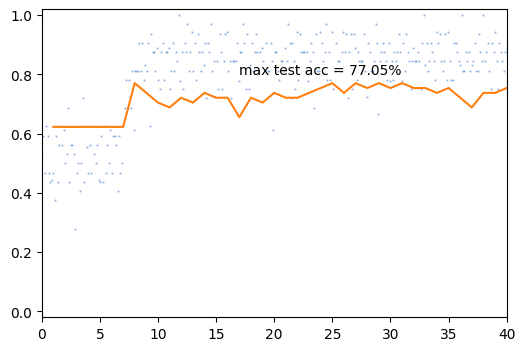

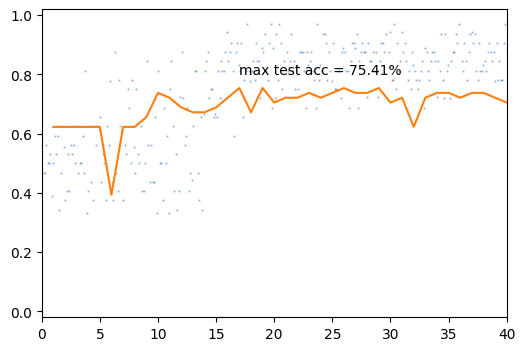

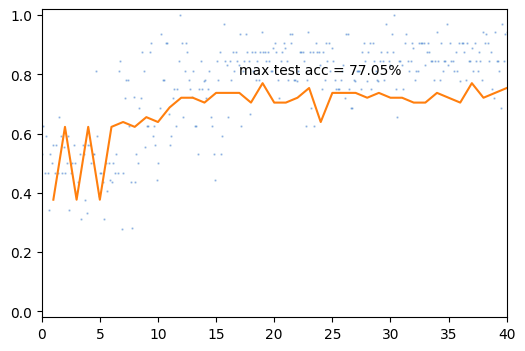

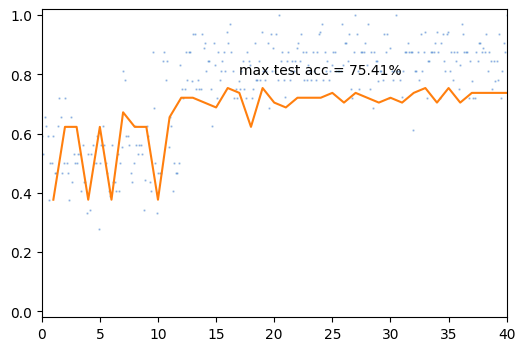

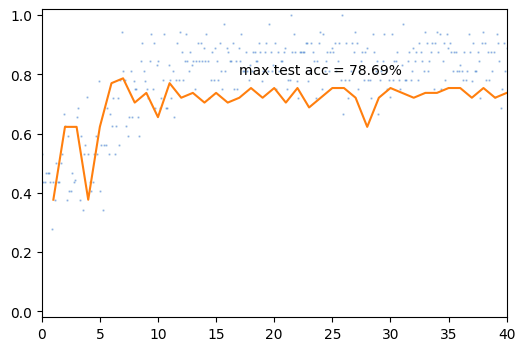

In [29]:
heart_models = [
    create_model("linear_relu", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_logplus", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_logmin", num_features=13, num_classes=2, num_layers=2).to(device),
]

for model in heart_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in heart_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.09535234966273315)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.09535234966273315,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.08645911829739474)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.08645911829739474,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0641828174926708)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.0641828174926708,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_logplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.08740666664969698)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.08740666664969698,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_logmin":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.23184639549603286)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.23184639549603286,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        heart_train_loader,
        heart_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [30]:
linear_accs = []
maxplus_accs = []
minplus_accs = []
logplus_accs = []
logmin_accs = []

for i in range(100):
    print(i)

    heart_models = [
        create_model("linear_relu", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_logplus", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_logmin", num_features=13, num_classes=2, num_layers=2).to(device),
    ]

    loss = nn.CrossEntropyLoss()
    epochs = 40

    for model in heart_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.09535234966273315)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.09535234966273315,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )

            linear_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.08645911829739474)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.08645911829739474,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0641828174926708)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.0641828174926708,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )

            minplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.08740666664969698)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.08740666664969698,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )

            logplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logmin":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.23184639549603286)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.23184639549603286,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )

            logmin_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")

    display.clear_output(wait=True)

print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))
print('-----')
print(min(logplus_accs))
print(quantiles(logplus_accs))
print(max(logplus_accs))
print('-----')
print(min(logmin_accs))
print(quantiles(logmin_accs))
print(max(logmin_accs))

0.7540983606557377
[0.7704918032786885, 0.7704918032786885, 0.7868852459016393]
0.8032786885245902
-----
0.7540983606557377
[0.7540983606557377, 0.7704918032786885, 0.7704918032786885]
0.8032786885245902
-----
0.7377049180327869
[0.7704918032786885, 0.7704918032786885, 0.7704918032786885]
0.7868852459016393
-----
0.7377049180327869
[0.7540983606557377, 0.7704918032786885, 0.7704918032786885]
0.8032786885245902
-----
0.7540983606557377
[0.7540983606557377, 0.7704918032786885, 0.7704918032786885]
0.7868852459016393


# Circles

In [25]:
find_best_model_for(config={
    "model_name": "linear_relu",
    "features": 2,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": circles_train_loader,
    "testloader": circles_test_loader,
    "epochs": 15,
})

{'accuracy': 0.6141065830721003, 'config': {'model_name': 'linear_relu', 'features': 2, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001FEC3E4B280>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001FEFCD93F70>, 'epochs': 15, 'lr': 0.1089388352430661}}


In [9]:
find_best_model_for(config={
    "model_name": "linear_maxplus",
    "features": 2,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": circles_train_loader,
    "testloader": circles_test_loader,
    "epochs": 15,
})

{'accuracy': 0.6266457680250783, 'config': {'model_name': 'linear_maxplus', 'features': 2, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000246E00E72E0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000246E00E7340>, 'epochs': 15, 'lr': 0.5446909239462105}}


In [10]:
find_best_model_for(config={
    "model_name": "linear_minplus",
    "features": 2,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": circles_train_loader,
    "testloader": circles_test_loader,
    "epochs": 15,
})

{'accuracy': 0.6266457680250783, 'config': {'model_name': 'linear_minplus', 'features': 2, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x00000246E00E61A0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x00000246E00E72E0>, 'epochs': 15, 'lr': 0.18804057844903743}}


In [9]:
find_best_model_for(config={
    "model_name": "linear_logplus",
    "features": 2,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": circles_train_loader,
    "testloader": circles_test_loader,
    "epochs": 15,
})

{'accuracy': 0.39561128526645767, 'config': {'model_name': 'linear_logplus', 'features': 2, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001E095A894E0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001E095A8BC40>, 'epochs': 15, 'lr': 0.37405924059868123}}


In [10]:
find_best_model_for(config={
    "model_name": "linear_logmin",
    "features": 2,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": circles_train_loader,
    "testloader": circles_test_loader,
    "epochs": 15,
})

{'accuracy': 0.39561128526645767, 'config': {'model_name': 'linear_logmin', 'features': 2, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001E01B38B250>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001E01B38B610>, 'epochs': 15, 'lr': 0.7383342580385768}}


linear/relu model has 256 parameters
linear/maxplus model has 256 parameters
linear/minplus model has 256 parameters
linear/logplus model has 258 parameters
linear/logmin model has 258 parameters


''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

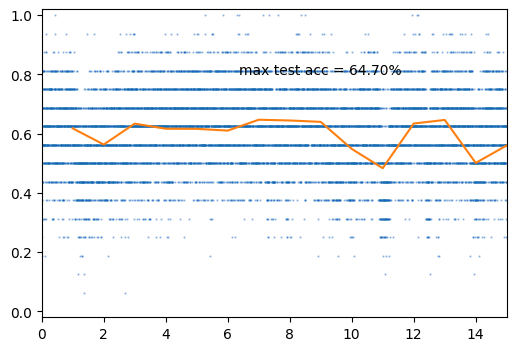

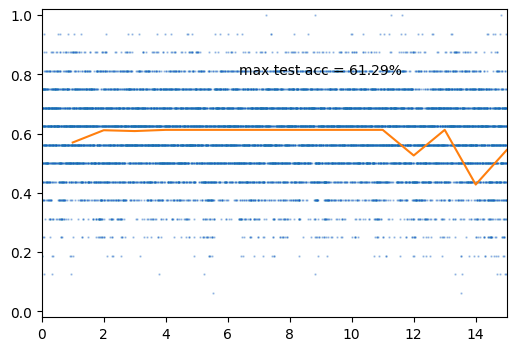

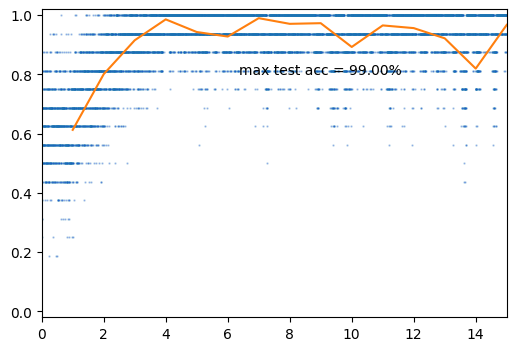

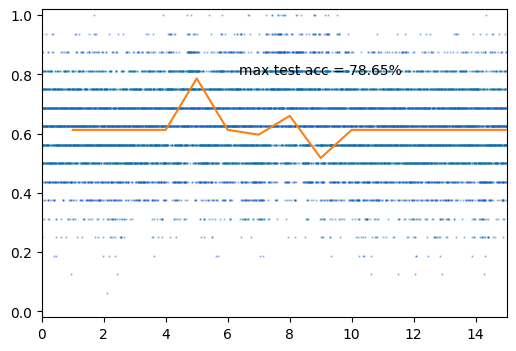

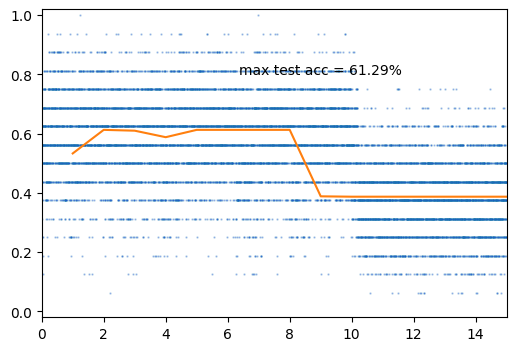

In [11]:
circles_models = [
    create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logmin", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in circles_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 15

for model in circles_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.1089388352430661)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.1089388352430661,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.5446909239462105)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.5446909239462105,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.18804057844903743)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.18804057844903743,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_logplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.37405924059868123)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.37405924059868123,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_logmin":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.7383342580385768)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.7383342580385768,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        circles_train_loader,
        circles_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [9]:
linear_accs = []
maxplus_accs = []
minplus_accs = []
logplus_accs = []
logmin_accs = []

for i in range(100):
    print(i)

    circles_models = [
        create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logmin", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]

    loss = nn.CrossEntropyLoss()
    epochs = 15

    for model in circles_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.1089388352430661)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.1089388352430661,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )

            linear_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.5446909239462105)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.5446909239462105,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.18804057844903743)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.18804057844903743,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )

            minplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.37405924059868123)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.37405924059868123,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )

            logplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logmin":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.7383342580385768)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.7383342580385768,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )

            logmin_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")

    display.clear_output(wait=True)

linear_accs = list(filter(lambda acc: acc > 0.5, linear_accs))
print(f"Removed {100 - len(linear_accs)} outliers from linear_accs")
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
maxplus_accs = list(filter(lambda acc: acc > 0.5, maxplus_accs))
print(f"Removed {100 - len(maxplus_accs)} outliers from maxplus_accs")
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
minplus_accs = list(filter(lambda acc: acc > 0.5, minplus_accs))
print(f"Removed {100 - len(minplus_accs)} outliers from minplus_accs")
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))
print('-----')
logplus_accs = list(filter(lambda acc: acc > 0.5, logplus_accs))
print(f"Removed {100 - len(logplus_accs)} outliers from logplus_accs")
print(min(logplus_accs))
print(quantiles(logplus_accs))
print(max(logplus_accs))
print('-----')
logmin_accs = list(filter(lambda acc: acc > 0.5, logmin_accs))
print(f"Removed {100 - len(logmin_accs)} outliers from logmin_accs")
print(min(logmin_accs))
print(quantiles(logmin_accs))
print(max(logmin_accs))

Removed 1 outliers from linear_accs
0.5884012539184953
[0.6313479623824452, 0.7084639498432602, 0.8238244514106583]
0.9492163009404389
-----
Removed 0 outliers from maxplus_accs
0.6241379310344828
[0.6241379310344828, 0.6241379310344828, 0.6407523510971787]
0.95141065830721
-----
Removed 0 outliers from minplus_accs
0.6241379310344828
[0.9525078369905956, 0.9749216300940439, 0.9905956112852664]
0.9996865203761756
-----
Removed 0 outliers from logplus_accs
0.6241379310344828
[0.6241379310344828, 0.6241379310344828, 0.7034482758620689]
0.9592476489028213
-----
Removed 0 outliers from logmin_accs
0.6241379310344828
[0.6241379310344828, 0.6241379310344828, 0.6241379310344828]
0.6783699059561129


# Rings

In [9]:
find_best_model_for(config={
    "model_name": "linear_relu",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": rings_train_loader,
    "testloader": rings_test_loader,
    "epochs": 20,
})

{'accuracy': 0.5005555555555555, 'config': {'model_name': 'linear_relu', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000002535E7004C0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000002535E7010F0>, 'epochs': 20, 'lr': 0.09584412417639646}}


In [9]:
find_best_model_for(config={
    "model_name": "linear_maxplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": rings_train_loader,
    "testloader": rings_test_loader,
    "epochs": 20,
})

{'accuracy': 0.9585555555555556, 'config': {'model_name': 'linear_maxplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA2261E70>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA2261E40>, 'epochs': 20, 'lr': 0.05145990822056955}}


In [10]:
find_best_model_for(config={
    "model_name": "linear_minplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": rings_train_loader,
    "testloader": rings_test_loader,
    "epochs": 20,
})

{'accuracy': 0.9595555555555556, 'config': {'model_name': 'linear_minplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA017CAF0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA017C0D0>, 'epochs': 20, 'lr': 0.06283481917964193}}


In [11]:
find_best_model_for(config={
    "model_name": "linear_logplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": rings_train_loader,
    "testloader": rings_test_loader,
    "epochs": 20,
})

{'accuracy': 0.9755555555555555, 'config': {'model_name': 'linear_logplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA017C160>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA017C0A0>, 'epochs': 20, 'lr': 0.05131424560271833}}


In [12]:
find_best_model_for(config={
    "model_name": "linear_logmin",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": rings_train_loader,
    "testloader": rings_test_loader,
    "epochs": 20,
})

{'accuracy': 0.9637777777777777, 'config': {'model_name': 'linear_logmin', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE593400>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE591510>, 'epochs': 20, 'lr': 0.05108881261434647}}


linear/relu model has 264 parameters
linear/maxplus model has 264 parameters
linear/minplus model has 264 parameters
linear/logplus model has 266 parameters
linear/logmin model has 266 parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

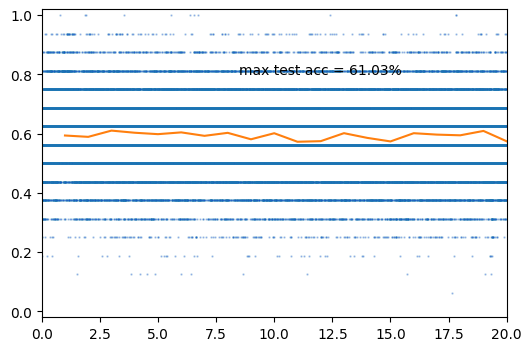

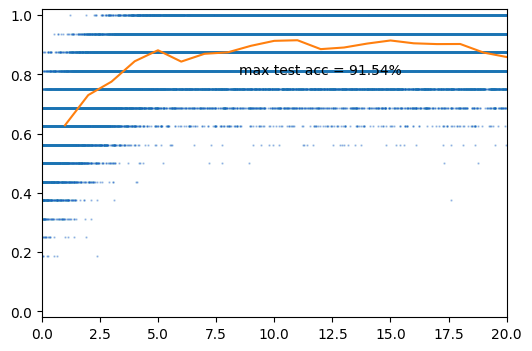

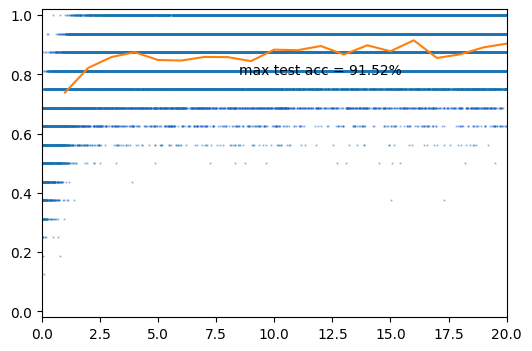

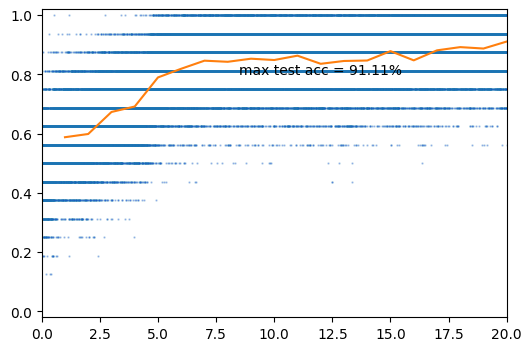

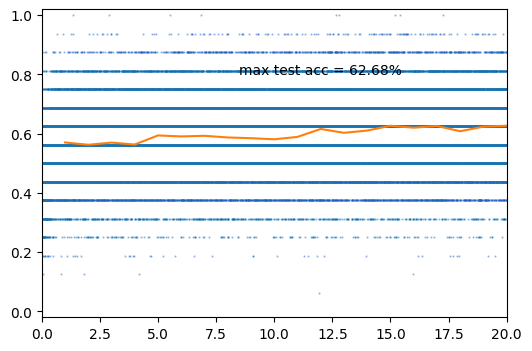

In [9]:
rings_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logmin", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in rings_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.09584412417639646)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.09584412417639646,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.05145990822056955)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.05145990822056955,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.06283481917964193)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.06283481917964193,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_logplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.05131424560271833)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.05131424560271833,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_logmin":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.05108881261434647)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.05108881261434647,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        rings_train_loader,
        rings_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [10]:
linear_accs = []
maxplus_accs = []
minplus_accs = []
logplus_accs = []
logmin_accs = []

for i in range(100):
    print(i)

    rings_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logmin", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]

    loss = nn.CrossEntropyLoss()
    epochs = 20

    for model in rings_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.08386054983438872)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.08386054983438872,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            linear_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.05145990822056955)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.05145990822056955,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.06283481917964193)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.06283481917964193,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            minplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.05131424560271833)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.05131424560271833,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            logplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logmin":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.05108881261434647)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.05108881261434647,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            logmin_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")

    display.clear_output(wait=True)

linear_accs = list(filter(lambda acc: acc > 0.5, linear_accs))
print(f"Removed {100 - len(linear_accs)} outliers from linear_accs")
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
maxplus_accs = list(filter(lambda acc: acc > 0.5, maxplus_accs))
print(f"Removed {100 - len(maxplus_accs)} outliers from maxplus_accs")
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
minplus_accs = list(filter(lambda acc: acc > 0.5, minplus_accs))
print(f"Removed {100 - len(minplus_accs)} outliers from minplus_accs")
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))
print('-----')
logplus_accs = list(filter(lambda acc: acc > 0.5, logplus_accs))
print(f"Removed {100 - len(logplus_accs)} outliers from logplus_accs")
print(min(logplus_accs))
print(quantiles(logplus_accs))
print(max(logplus_accs))
print('-----')
logmin_accs = list(filter(lambda acc: acc > 0.5, logmin_accs))
print(f"Removed {100 - len(logmin_accs)} outliers from logmin_accs")
print(min(logmin_accs))
print(quantiles(logmin_accs))
print(max(logmin_accs))

Removed 10 outliers from linear_accs
0.5461111111111111
[0.6910000000000001, 0.7609444444444444, 0.8320000000000001]
0.8934444444444445
-----
Removed 0 outliers from maxplus_accs
0.8521111111111112
[0.8885555555555555, 0.9011666666666667, 0.9130555555555556]
0.9445555555555556
-----
Removed 0 outliers from minplus_accs
0.8297777777777777
[0.889, 0.8981111111111111, 0.9124722222222222]
0.944
-----
Removed 0 outliers from logplus_accs
0.5225555555555556
[0.6092500000000001, 0.6198333333333332, 0.8921388888888889]
0.9347777777777778
-----
Removed 0 outliers from logmin_accs
0.5912222222222222
[0.613, 0.624, 0.8866944444444445]
0.9556666666666667


In [13]:
## 10 outliers for the Linear/ReLU model means that those are not necessarily all outliers. Instead, run Linear/ReLU only for different threshold

linear_accs = []

for i in range(100):
    print(i)

    model = create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device)
    loss = nn.CrossEntropyLoss()
    epochs = 20

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.08386054983438872)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.08386054983438872,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(rings_train),
        epochs=epochs,
    )

    linear_accs.append(
        train(
            model,
            device,
            rings_train_loader,
            rings_test_loader,
            optimizer,
            scheduler,
            loss,
            epochs,
            statistics_mode=True
        )
    )

    display.clear_output(wait=True)

linear_accs = list(filter(lambda acc: acc > 0.3, linear_accs))
print(f"Removed {100 - len(linear_accs)} outliers from linear_accs")
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))

Removed 0 outliers from linear_accs
0.4988888888888889
[0.6197777777777778, 0.7424999999999999, 0.8191111111111111]
0.8913333333333333


# Spheres

In [13]:
find_best_model_for(config={
    "model_name": "linear_relu",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": spheres_train_loader,
    "testloader": spheres_test_loader,
    "epochs": 20,
})

{'accuracy': 0.4753968253968254, 'config': {'model_name': 'linear_relu', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE592E60>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE592B00>, 'epochs': 20, 'lr': 0.04916699307854641}}


In [14]:
find_best_model_for(config={
    "model_name": "linear_maxplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": spheres_train_loader,
    "testloader": spheres_test_loader,
    "epochs": 20,
})

{'accuracy': 0.801058201058201, 'config': {'model_name': 'linear_maxplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EA017C0A0>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE590190>, 'epochs': 20, 'lr': 0.061381214896246206}}


In [15]:
find_best_model_for(config={
    "model_name": "linear_minplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": spheres_train_loader,
    "testloader": spheres_test_loader,
    "epochs": 20,
})

{'accuracy': 0.8222222222222222, 'config': {'model_name': 'linear_minplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE590B50>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x0000015EEE590D30>, 'epochs': 20, 'lr': 0.06476291060180032}}


In [11]:
find_best_model_for(config={
    "model_name": "linear_logplus",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": spheres_train_loader,
    "testloader": spheres_test_loader,
    "epochs": 20,
})

{'accuracy': 0.6592592592592592, 'config': {'model_name': 'linear_logplus', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001D49F9D1B10>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001D49A5943A0>, 'epochs': 20, 'lr': 0.09648214143808401}}


In [12]:
find_best_model_for(config={
    "model_name": "linear_logmin",
    "features": 3,
    "classes": 2,
    "layers": 2,
    "channels": 8,
    "trainloader": spheres_train_loader,
    "testloader": spheres_test_loader,
    "epochs": 20,
})

{'accuracy': 0.6755291005291005, 'config': {'model_name': 'linear_logmin', 'features': 3, 'classes': 2, 'layers': 2, 'channels': 8, 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x000001D49A606C80>, 'testloader': <torch.utils.data.dataloader.DataLoader object at 0x000001D4969FC1F0>, 'epochs': 20, 'lr': 0.09112007688145611}}


linear/relu model has 264 parameters
linear/maxplus model has 264 parameters
linear/minplus model has 264 parameters
linear/logplus model has 266 parameters
linear/logmin model has 266 parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

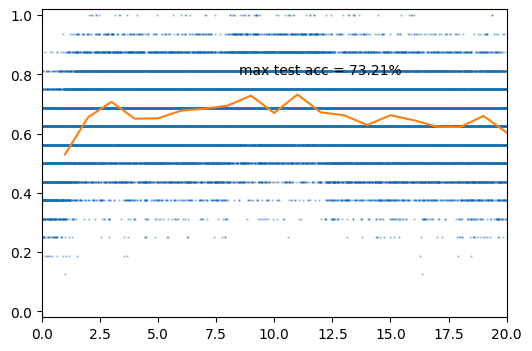

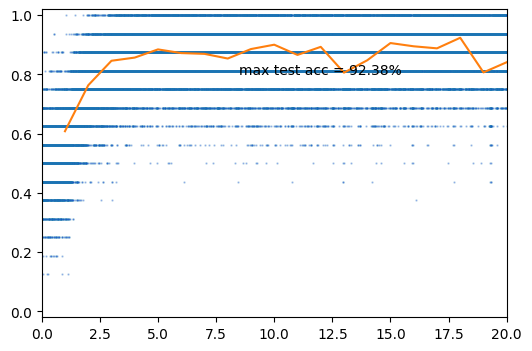

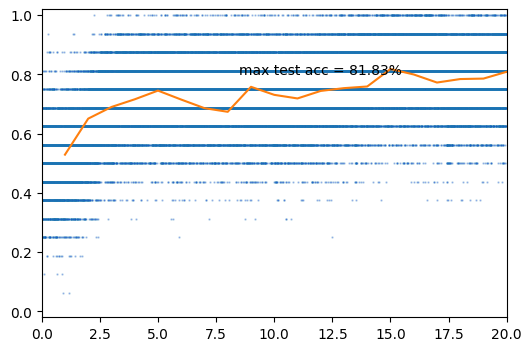

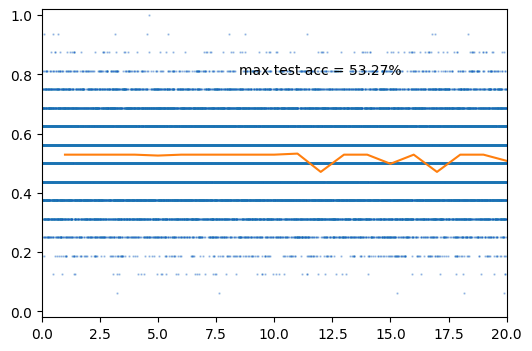

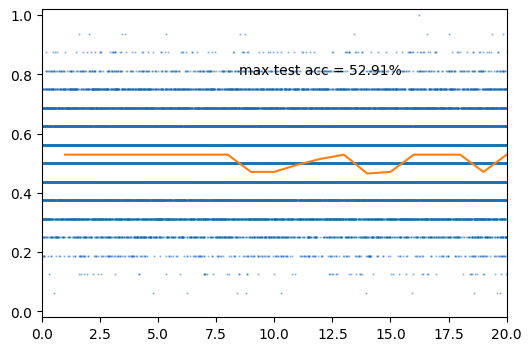

In [14]:
spheres_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_logmin", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in spheres_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.04916699307854641)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.04916699307854641,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.061381214896246206)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.061381214896246206,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.06476291060180032)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.06476291060180032,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_logplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.09648214143808401)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.09648214143808401,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_logmin":
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.09112007688145611)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.09112007688145611,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        spheres_train_loader,
        spheres_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [9]:
linear_accs = []
maxplus_accs = []
minplus_accs = []
logplus_accs = []
logmin_accs = []

for i in range(100):
    print(i)

    spheres_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_logmin", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]

    loss = nn.CrossEntropyLoss()
    epochs = 20

    for model in spheres_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.04916699307854641)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.04916699307854641,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            linear_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.061381214896246206)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.061381214896246206,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.06476291060180032)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.06476291060180032,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            minplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.09648214143808401)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.09648214143808401,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            logplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_logmin":
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.09112007688145611)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=0.09112007688145611,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            logmin_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")

    display.clear_output(wait=True)

linear_accs = list(filter(lambda acc: acc > 0.3, linear_accs))
print(f"Removed {100 - len(linear_accs)} outliers from linear_accs")
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
maxplus_accs = list(filter(lambda acc: acc > 0.3, maxplus_accs))
print(f"Removed {100 - len(maxplus_accs)} outliers from maxplus_accs")
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
minplus_accs = list(filter(lambda acc: acc > 0.3, minplus_accs))
print(f"Removed {100 - len(minplus_accs)} outliers from minplus_accs")
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))
print('-----')
logplus_accs = list(filter(lambda acc: acc > 0.3, logplus_accs))
print(f"Removed {100 - len(logplus_accs)} outliers from logplus_accs")
print(min(logplus_accs))
print(quantiles(logplus_accs))
print(max(logplus_accs))
print('-----')
logmin_accs = list(filter(lambda acc: acc > 0.3, logmin_accs))
print(f"Removed {100 - len(logmin_accs)} outliers from logmin_accs")
print(min(logmin_accs))
print(quantiles(logmin_accs))
print(max(logmin_accs))

Removed 0 outliers from linear_accs
0.475
[0.6329034391534392, 0.7267195767195767, 0.8000330687830688]
0.8842592592592593
-----
Removed 0 outliers from maxplus_accs
0.6824074074074075
[0.8276785714285715, 0.8421957671957672, 0.9322089947089948]
0.9927248677248677
-----
Removed 0 outliers from minplus_accs
0.6775132275132275
[0.8148148148148148, 0.8406746031746032, 0.8956349206349207]
0.9861111111111112
-----
Removed 0 outliers from logplus_accs
0.525
[0.525, 0.525, 0.525]
0.9514550264550264
-----
Removed 0 outliers from logmin_accs
0.525
[0.525, 0.525, 0.5285383597883598]
0.9572751322751323
